In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


Here we learn hw to forecasting using deep learning technique step by step 

First we do forecasting on Univariate Single Step using LSTM

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
df = pd.read_csv('drive/MyDrive/Data/Metro_Interstate_Traffic_Volume.csv')

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [ ]:
df.shape

(48204, 9)

In [ ]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

For the train/test split, let’s hold back ten hours of data (i.e., ten records), which we can use to validate the data after training on the past data.

In [ ]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [ ]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [ ]:
uni_data = uni_data.values
uni_data

array([5545, 4516, 4767, ..., 2882, 3701, 4049])

In [ ]:
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))
x_rescaled

array([[0.76167582],
       [0.62032967],
       [0.65480769],
       ...,
       [0.39587912],
       [0.50837912],
       [0.55618132]])

Define a function to prepare univariate data that is suitable for a time series

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

As we are doing a single-step forecast, let’s allow the model to see/train on the past 48 hours of data and try to forecast the 49th hour. Hence, use horizon = 1.

In [ ]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]


In [ ]:
print ('\n Target horizon')
print (y_train_uni[0])


 Target horizon
[[0.71126374]]


Prepare the training and validation time-series data using the tf.data function, which is a much faster and more efficient way of feeding data to the model

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
val_univariate

<RepeatDataset shapes: ((None, 48, 1), (None, 1, 1)), types: (tf.float64, tf.float64)>

The best weights are stored at model_path.

In [ ]:
model_path = 'drive/MyDrive/Data/Lstm_univarient_1.h5'

in LSTM x input shape is little different thats y we do that in function

In [ ]:
x_train_uni.shape

(29952, 48, 1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])
lstm_model.compile(optimizer='adam', loss='mse')

Configure the model and start training with early stopping and checkpointing.
Early stopping stops training when monitored loss starts to increase above patience.
Checkpointing saves model weights as it reached minimum loss.

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 35s 18ms/step - loss: 0.1069 - val_loss: 0.0335
Epoch 2/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0359 - val_loss: 0.0284
Epoch 3/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0267 - val_loss: 0.0259
Epoch 4/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0202 - val_loss: 0.0125
Epoch 5/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0180 - val_loss: 0.0126
Epoch 6/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0153 - val_loss: 0.0110
Epoch 7/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0157 - val_loss: 0.0103
Epoch 8/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0146 - val_loss: 0.0100
Epoch 9/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0130 - val_loss: 0.0111
Epoch 10/150
100/100 [==============================] - 1s 11ms/step - loss: 0.01

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [ ]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 48, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


Plot the loss and val_loss against the epoch.

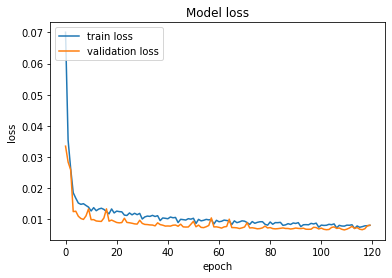

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In machine and deep learning, there are three scenarios.

Underfitting, when the validation loss is less than the training loss

Overfitting, when the validation loss is higher than the training loss

Good fit, when the validation loss is equal to the training loss

We need to forecast the next ten steps, but our model predicts only one time step, so let’s take the last 48 hours of data from the training and increment one prediction at a time and forecast the next values.

In [ ]:
uni = df['traffic_volume']
validatehori = uni.tail(48)
validatehori

date_time
2018-09-28 11:00:00    4863
2018-09-28 12:00:00    5066
2018-09-28 13:00:00    4898
2018-09-28 14:00:00    5193
2018-09-28 15:00:00    5838
2018-09-28 16:00:00    6188
2018-09-28 17:00:00    5695
2018-09-28 18:00:00    5104
2018-09-28 19:00:00    4286
2018-09-28 20:00:00    3538
2018-09-28 21:00:00    3058
2018-09-28 22:00:00    2713
2018-09-28 23:00:00    3544
2018-09-29 00:00:00    1733
2018-09-29 01:00:00     867
2018-09-29 02:00:00     524
2018-09-29 03:00:00     359
2018-09-29 04:00:00     425
2018-09-29 05:00:00     743
2018-09-29 06:00:00    1359
2018-09-29 07:00:00    2036
2018-09-29 08:00:00    3073
2018-09-29 09:00:00    3725
2018-09-29 10:00:00    4059
2018-09-29 11:00:00    4378
2018-09-29 12:00:00    4657
2018-09-29 13:00:00    4553
2018-09-29 14:00:00    4618
2018-09-29 15:00:00    4564
2018-09-29 16:00:00    4735
2018-09-29 17:00:00    4878
2018-09-29 18:00:00    4569
2018-09-29 20:00:00    3338
2018-09-29 21:00:00    2950
2018-09-29 22:00:00    2607
2018-09-29

In [ ]:
validatehist = validatehori.values

In [ ]:
validatehist

array([4863, 5066, 4898, 5193, 5838, 6188, 5695, 5104, 4286, 3538, 3058,
       2713, 3544, 1733,  867,  524,  359,  425,  743, 1359, 2036, 3073,
       3725, 4059, 4378, 4657, 4553, 4618, 4564, 4735, 4878, 4569, 3338,
       2950, 2607, 3856, 1826,  920,  696,  364,  335,  444,  802, 1175,
       2002, 2882, 3701, 4049])

In [ ]:
result = []
# Define Forecast length here
window_len = 10
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

for i in range(1, window_len+1):
    
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    print(val_rescaled)


predicted : [[0.6222379]]
[0.80830343 0.77960021 0.83000171 0.94020161 1.         0.91576969
 0.81479583 0.67503844 0.54724073 0.46523151 0.40628737 0.54826585
 0.23885187 0.09089356 0.03229113 0.00410046 0.01537673 0.06970784
 0.17495302 0.29062019 0.46779429 0.57919016 0.63625491 0.69075688
 0.73842474 0.72065607 0.73176149 0.72253545 0.75175124 0.77618315
 0.72338971 0.51307022 0.44677943 0.388177   0.60157184 0.25474116
 0.09994874 0.06167777 0.00495472 0.         0.01862293 0.07978814
 0.14351615 0.28481121 0.43516146 0.5750897  0.63454639 0.62223792]
predicted : [[0.61836314]]
[0.77960021 0.83000171 0.94020161 1.         0.91576969 0.81479583
 0.67503844 0.54724073 0.46523151 0.40628737 0.54826585 0.23885187
 0.09089356 0.03229113 0.00410046 0.01537673 0.06970784 0.17495302
 0.29062019 0.46779429 0.57919016 0.63625491 0.69075688 0.73842474
 0.72065607 0.73176149 0.72253545 0.75175124 0.77618315 0.72338971
 0.51307022 0.44677943 0.388177   0.60157184 0.25474116 0.09994874
 0.06167

In [ ]:
result_inv_trans = scaler_x.inverse_transform(result)
result_inv_trans

array([[3976.95855021],
       [3954.27947021],
       [3947.08376038],
       [3937.48785257],
       [3910.5222562 ],
       [3782.33249629],
       [3504.2580474 ],
       [3098.99682832],
       [2636.54391497],
       [2177.33161777]])

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 507606.7413453888
MAE is : 592.4131015181541
RMSE is : 712.4652562373752
MAPE is : 60.37939572212584
R2 is : 0.6704540630553437



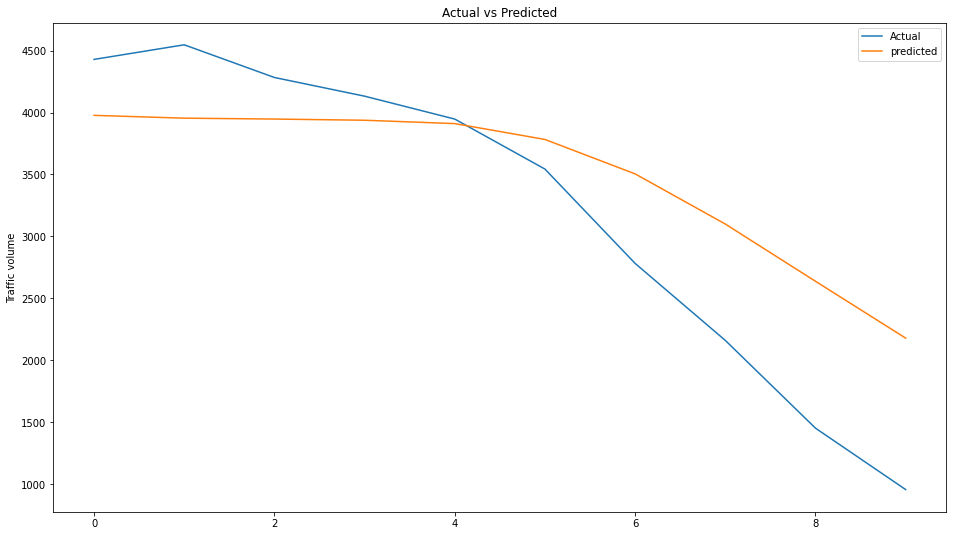

In [ ]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## LSTM Univariate Horizon Style in Action

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [ ]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [ ]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

As we are doing horizon-style forecasts, let’s allow the model to see/train on the past 48 hours of data and try forecasting the next ten hours of results; hence, use horizon = 10.

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
    X = []
    y = []

    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indicesx = range(i-window, i)
        X.append(np.reshape(dataset[indicesx], (window, 1)))
        indicesy = range(i, i+horizon)
        y.append(dataset[indicesy])
    return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]
 [0.75563187]
 [0.78475275]
 [0.86428571]
 [0.83200549]
 [0.67403846]
 [0.48118132]
 [0.41717033]
 [0.38763736]
 [0.27362637]]


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
model_path = 'drive/MyDrive/Data/Lstm_univarient_2.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 4s 18ms/step - loss: 0.1234 - val_loss: 0.0499
Epoch 2/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0576 - val_loss: 0.0482
Epoch 3/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0510 - val_loss: 0.0601
Epoch 4/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0502 - val_loss: 0.0428
Epoch 5/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0518 - val_loss: 0.0398
Epoch 6/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0453 - val_loss: 0.0400
Epoch 7/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0471 - val_loss: 0.0362
Epoch 8/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0446 - val_loss: 0.0361
Epoch 9/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0409 - val_loss: 0.0443
Epoch 10/150
100/100 [==============================] - 1s 11ms/step - loss: 0.038

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [ ]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 71,510
Trainable params: 71,510
Non-trainable params: 0
_________________________________________________________________


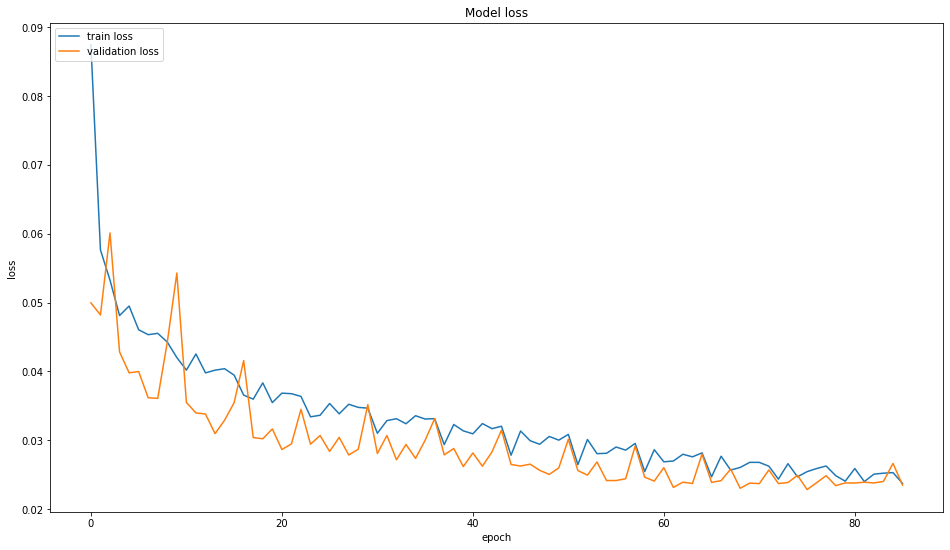

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['traffic_volume']
validatehori = uni.tail(48)

In [ ]:
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

In [ ]:
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))

In [ ]:
Predicted_results = Trained_model.predict(val_rescaled)

In [ ]:
Predicted_results

array([[0.1270701 , 0.13929272, 0.17773718, 0.23745096, 0.313996  ,
        0.38978118, 0.4507719 , 0.49459267, 0.5268972 , 0.5571087 ]],
      dtype=float32)

In [ ]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results)

In [ ]:
Predicted_inver_res

array([[1076.1276, 1150.6855, 1385.1968, 1749.4509, 2216.3755, 2678.6653,
        3050.7087, 3318.0151, 3515.0728, 3699.363 ]], dtype=float32)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res[0])

Evaluation metric results:-
MSE is : 927866.7983754769
MAE is : 846.0789672851563
RMSE is : 963.2584276171566
MAPE is : 126.3748854905322
R2 is : 0.49284652525649253



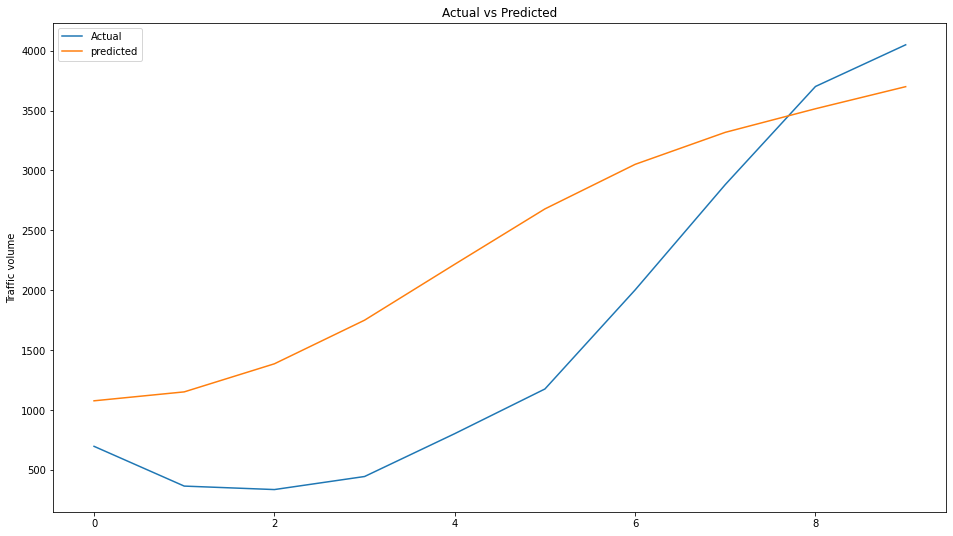

In [ ]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

##  Bidirectional LSTM Univarient  Single Step Style

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [ ]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [ ]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]]


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                               input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')


In [ ]:
 model_path = 'drive/MyDrive/Data/BiLstm_univarient_1.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 8s 33ms/step - loss: 0.1331 - val_loss: 0.0734
Epoch 2/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0745 - val_loss: 0.0401
Epoch 3/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0418 - val_loss: 0.0285
Epoch 4/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0284 - val_loss: 0.0165
Epoch 5/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0256 - val_loss: 0.0169
Epoch 6/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0211 - val_loss: 0.0139
Epoch 7/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0205 - val_loss: 0.0127
Epoch 8/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0190 - val_loss: 0.0122
Epoch 9/150
100/100 [==============================] - 2s 21ms/step - loss: 0.0177 - val_loss: 0.0119
Epoch 10/150
100/100 [==============================] - 2s 21ms/step - loss: 0.016

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [ ]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 48, 200)           81600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 184,041
Trainable params: 184,041
Non-trainable params: 0
_________________________________________________________________


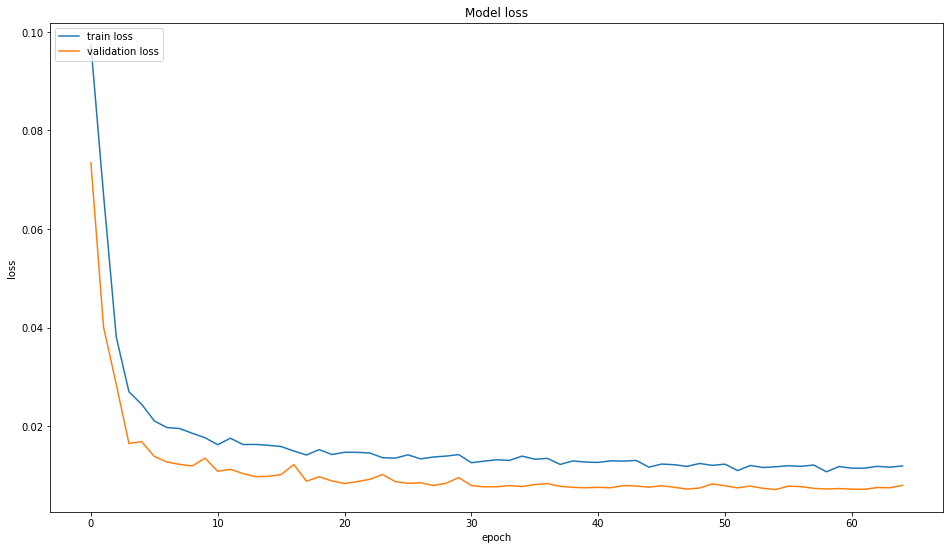

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['traffic_volume']
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = 10
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

for i in range(1, window_len+1):
    
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    print(val_rescaled)

predicted : [[0.6710615]]
[1.         0.92146341 0.68243902 0.50699187 0.41544715 0.38178862
 0.27674797 0.15886179 0.06471545 0.02601626 0.         0.01073171
 0.09252033 0.39837398 0.84878049 0.99186992 0.89382114 0.7300813
 0.69479675 0.74178862 0.77479675 0.74747967 0.79544715 0.9003252
 0.95723577 0.87707317 0.78097561 0.64796748 0.52634146 0.44829268
 0.39219512 0.52731707 0.23284553 0.09203252 0.03626016 0.00943089
 0.0201626  0.07186992 0.17203252 0.28211382 0.45073171 0.55674797
 0.61105691 0.66292683 0.70829268 0.69138211 0.70195122 0.67106152]
predicted : [[0.6264149]]
[0.92146341 0.68243902 0.50699187 0.41544715 0.38178862 0.27674797
 0.15886179 0.06471545 0.02601626 0.         0.01073171 0.09252033
 0.39837398 0.84878049 0.99186992 0.89382114 0.7300813  0.69479675
 0.74178862 0.77479675 0.74747967 0.79544715 0.9003252  0.95723577
 0.87707317 0.78097561 0.64796748 0.52634146 0.44829268 0.39219512
 0.52731707 0.23284553 0.09203252 0.03626016 0.00943089 0.0201626
 0.07186992 

In [ ]:
result_inv_trans = scaler_x.inverse_transform(result)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 873209.9390671629
MAE is : 724.226056419313
RMSE is : 934.4570290105174
MAPE is : 56.81505444274729
R2 is : 0.46603330874242743



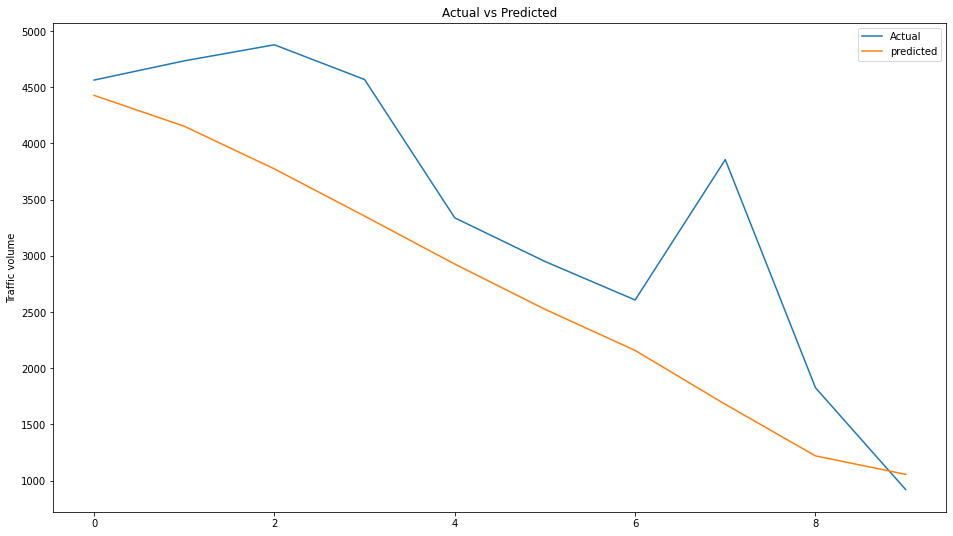

In [ ]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## BIdirectional LSTM Univariate Horizin is same sa lstm horizon 

## GRU Univarient Single step style

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)


In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [ ]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [ ]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]]


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])
GRU_model.compile(optimizer='adam', loss='mse')


In [ ]:
 model_path = 'drive/MyDrive/Data/gru_univarient_1.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 4s 17ms/step - loss: 0.0710 - val_loss: 0.0201
Epoch 2/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0216 - val_loss: 0.0131
Epoch 3/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0158 - val_loss: 0.0130
Epoch 4/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0146 - val_loss: 0.0111
Epoch 5/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0163 - val_loss: 0.0111
Epoch 6/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.0104
Epoch 7/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0147 - val_loss: 0.0104
Epoch 8/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0139 - val_loss: 0.0106
Epoch 9/150
100/100 [==============================] - 1s 10ms/step - loss: 0.0126 - val_loss: 0.0104
Epoch 10/150
100/100 [==============================] - 1s 10ms/step - loss: 0.011

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [ ]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 48, 100)           30900     
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________


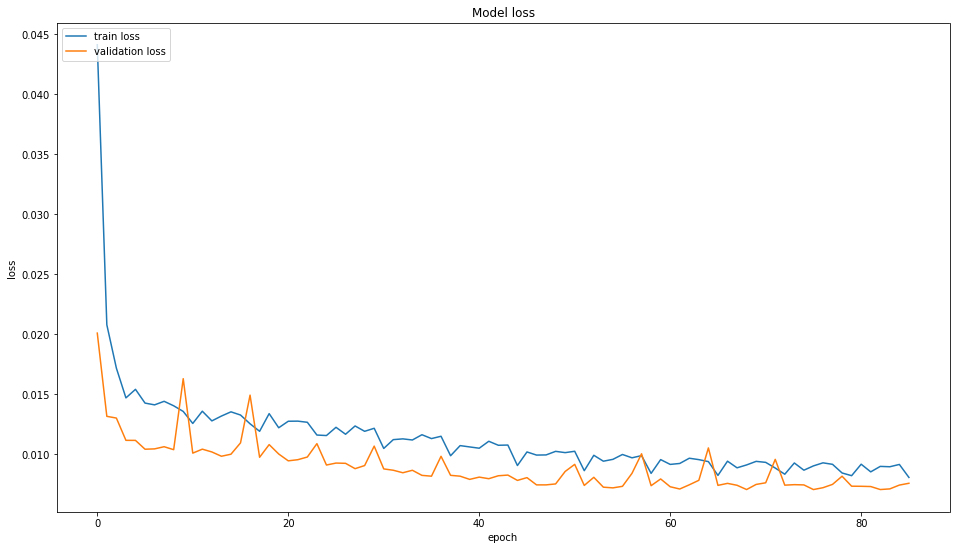

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['traffic_volume']
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = 10
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

for i in range(1, window_len+1):
    
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    print(val_rescaled)

predicted : [[0.14566505]]
[0.43918699 0.87544715 0.91788618 0.79349593 0.68276423 0.7104065
 0.7395122  0.72943089 0.75479675 0.90910569 1.         0.92146341
 0.68243902 0.50699187 0.41544715 0.38178862 0.27674797 0.15886179
 0.06471545 0.02601626 0.         0.01073171 0.09252033 0.39837398
 0.84878049 0.99186992 0.89382114 0.7300813  0.69479675 0.74178862
 0.77479675 0.74747967 0.79544715 0.9003252  0.95723577 0.87707317
 0.78097561 0.64796748 0.52634146 0.44829268 0.39219512 0.52731707
 0.23284553 0.09203252 0.03626016 0.00943089 0.0201626  0.14566505]
predicted : [[0.4935561]]
[0.87544715 0.91788618 0.79349593 0.68276423 0.7104065  0.7395122
 0.72943089 0.75479675 0.90910569 1.         0.92146341 0.68243902
 0.50699187 0.41544715 0.38178862 0.27674797 0.15886179 0.06471545
 0.02601626 0.         0.01073171 0.09252033 0.39837398 0.84878049
 0.99186992 0.89382114 0.7300813  0.69479675 0.74178862 0.77479675
 0.74747967 0.79544715 0.9003252  0.95723577 0.87707317 0.78097561
 0.6479674

In [ ]:
result_inv_trans = scaler_x.inverse_transform(result)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 1800618.8329853597
MAE is : 898.9025378882885
RMSE is : 1341.8713921182461
MAPE is : 94.6024712372662
R2 is : 0.05321712599395079



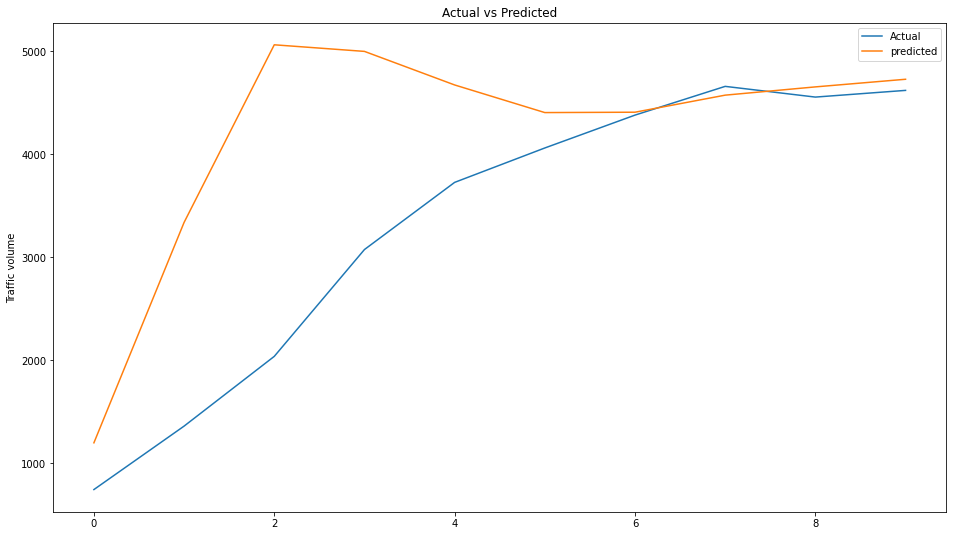

In [ ]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## ENCODER AND DECODER LSTM UNIVARIENT SINGLE

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [ ]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [ ]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]]


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni.shape[1]), 
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
 model_path = 'drive/MyDrive/Data/encoder_univarient_1.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = ED_lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 9s 32ms/step - loss: 0.1441 - val_loss: 0.0751
Epoch 2/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0746 - val_loss: 0.0758
Epoch 3/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0725 - val_loss: 0.0640
Epoch 4/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0378 - val_loss: 0.0118
Epoch 5/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 6/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0114 - val_loss: 0.0092
Epoch 7/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0117 - val_loss: 0.0093
Epoch 8/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 9/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0096 - val_loss: 0.0106
Epoch 10/150
100/100 [==============================] - 2s 17ms/step - loss: 0.009

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [ ]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 48, 50)            30200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 15)                3960      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 15)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 100)            46400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 50)             30200     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)             

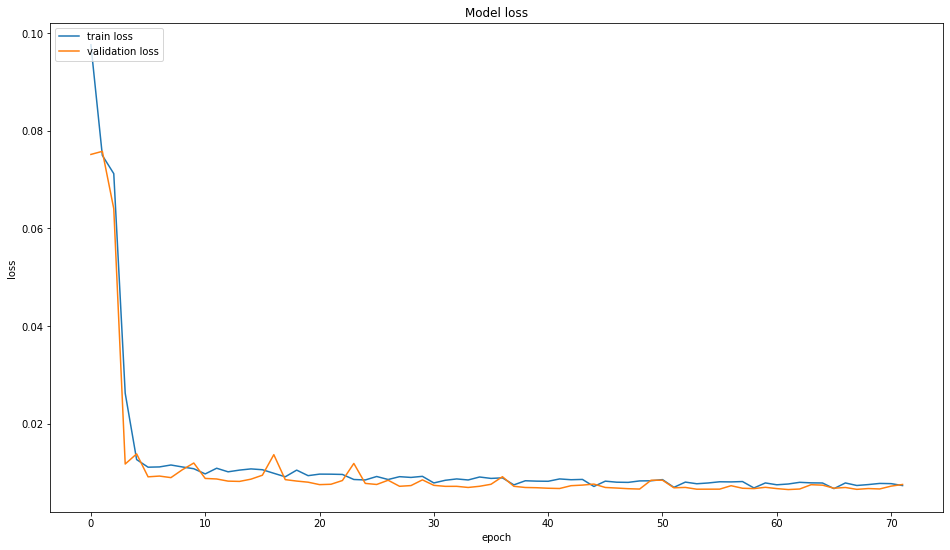

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['traffic_volume']
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = 10
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

for i in range(1, window_len+1):
    
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    print(val_rescaled)

predicted : [[[0.60099405]]]
[0.54276423 0.47089431 0.51609756 0.27186992 0.14764228 0.05739837
 0.0195122  0.00178862 0.01170732 0.1004878  0.43918699 0.87544715
 0.91788618 0.79349593 0.68276423 0.7104065  0.7395122  0.72943089
 0.75479675 0.90910569 1.         0.92146341 0.68243902 0.50699187
 0.41544715 0.38178862 0.27674797 0.15886179 0.06471545 0.02601626
 0.         0.01073171 0.09252033 0.39837398 0.84878049 0.99186992
 0.89382114 0.7300813  0.69479675 0.74178862 0.77479675 0.74747967
 0.79544715 0.9003252  0.95723577 0.87707317 0.78097561 0.60099405]
predicted : [[[0.46521786]]]
[0.47089431 0.51609756 0.27186992 0.14764228 0.05739837 0.0195122
 0.00178862 0.01170732 0.1004878  0.43918699 0.87544715 0.91788618
 0.79349593 0.68276423 0.7104065  0.7395122  0.72943089 0.75479675
 0.90910569 1.         0.92146341 0.68243902 0.50699187 0.41544715
 0.38178862 0.27674797 0.15886179 0.06471545 0.02601626 0.
 0.01073171 0.09252033 0.39837398 0.84878049 0.99186992 0.89382114
 0.7300813  

In [ ]:
result_inv_trans = scaler_x.inverse_transform(np.array(result).reshape(-1,1))

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 400143.7408998556
MAE is : 434.91185302734374
RMSE is : 632.569158985684
MAPE is : 143.26231032624915
R2 is : 0.8019124527364676



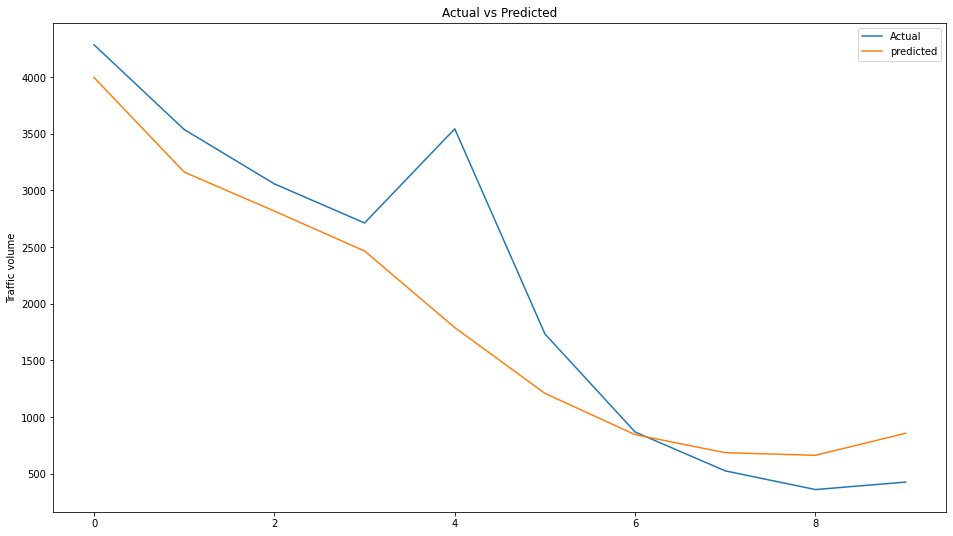

In [ ]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## CNN UNIVARIENT SINGLE STEP STYLE

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [ ]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [ ]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]]


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
 model_path = 'drive/MyDrive/Data/cnn_univarient_1.h5'

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 2s 5ms/step - loss: 0.0788 - val_loss: 0.0232
Epoch 2/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0284 - val_loss: 0.0167
Epoch 3/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0228 - val_loss: 0.0173
Epoch 4/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0208 - val_loss: 0.0143
Epoch 5/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0228 - val_loss: 0.0139
Epoch 6/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0195 - val_loss: 0.0127
Epoch 7/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0199 - val_loss: 0.0118
Epoch 8/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0110
Epoch 9/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0162 - val_loss: 0.0121
Epoch 10/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0148 - val_lo

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [ ]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 46, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 64)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                44190     
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

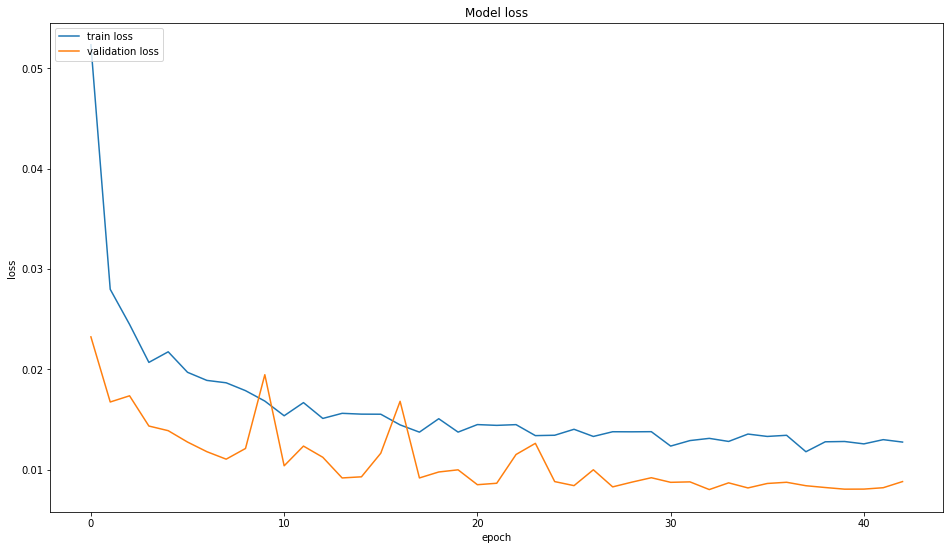

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
uni = df['traffic_volume']
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = 10
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

for i in range(1, window_len+1):
    
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    print(val_rescaled)


predicted : [[0.76146376]]
[0.81609756 0.68650407 0.71869919 0.7304065  0.70292683 0.75235772
 0.87674797 0.98097561 0.91918699 0.70894309 0.54276423 0.47089431
 0.51609756 0.27186992 0.14764228 0.05739837 0.0195122  0.00178862
 0.01170732 0.1004878  0.43918699 0.87544715 0.91788618 0.79349593
 0.68276423 0.7104065  0.7395122  0.72943089 0.75479675 0.90910569
 1.         0.92146341 0.68243902 0.50699187 0.41544715 0.38178862
 0.27674797 0.15886179 0.06471545 0.02601626 0.         0.01073171
 0.09252033 0.39837398 0.84878049 0.99186992 0.89382114 0.76146376]
predicted : [[0.6882713]]
[0.68650407 0.71869919 0.7304065  0.70292683 0.75235772 0.87674797
 0.98097561 0.91918699 0.70894309 0.54276423 0.47089431 0.51609756
 0.27186992 0.14764228 0.05739837 0.0195122  0.00178862 0.01170732
 0.1004878  0.43918699 0.87544715 0.91788618 0.79349593 0.68276423
 0.7104065  0.7395122  0.72943089 0.75479675 0.90910569 1.
 0.92146341 0.68243902 0.50699187 0.41544715 0.38178862 0.27674797
 0.15886179 0.06

In [ ]:
result_inv_trans = scaler_x.inverse_transform(result)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 168494.36935352656
MAE is : 289.5156793117523
RMSE is : 410.4806564912975
MAPE is : 10.807642901415583
R2 is : 0.3022874582558237



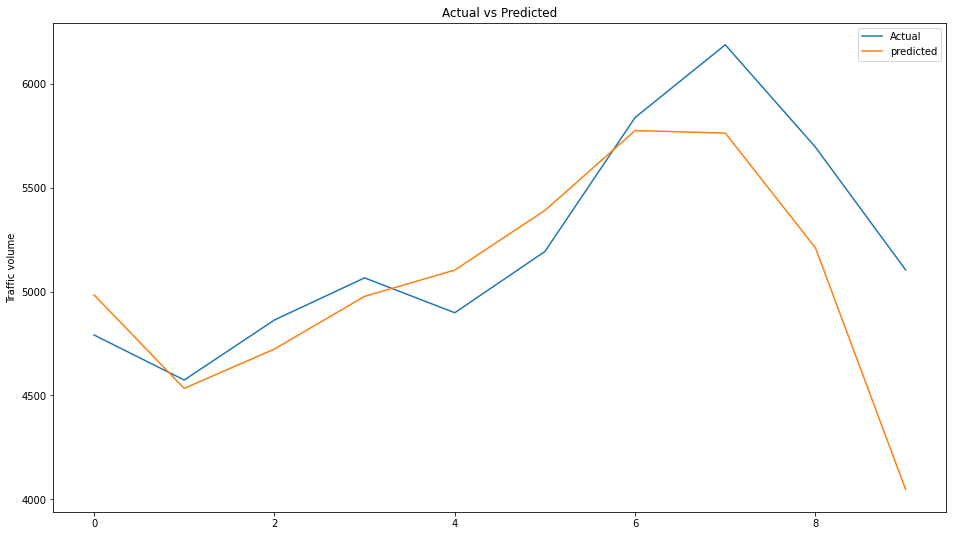

In [ ]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

Summary

In this chapter, you learned how to use single-step and horizon-style data preparation for a time series and solve univariate time-series problems using LSTM, bidirectional LSTM, GRU, auto-encoders, and CNNs. In the next chapter, you will learn how to solve multivariate time-series problems using bleeding-edge techniques.

In the previous chapter, you learned how to perform univariate time-series forecasting. In this chapter, you will look at single-step and horizon-style time-series forecasting data preparation and solve some multivariate time-series problems. A multivariate time series is a method where more than one variable is time dependent, and we use these variables to try to estimate a target variable.

## LSTM MULTIVARIENT HORIZON STYLE

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
 df = pd.read_csv('drive/MyDrive/Data/Metro_Interstate_Traffic_Volume.csv')

In [3]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [5]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [8]:
holiday_le = preprocessing.LabelEncoder()
df['holiday_le'] = holiday_le.fit_transform(df['holiday']) 
weather_main_le = preprocessing.LabelEncoder()
df['weather_main_le'] = weather_main_le.fit_transform(df['weather_main']) 
weather_description_le = preprocessing.LabelEncoder()
df['weather_description_le'] = weather_description_le.fit_transform(df['weather_description']) 

In [14]:
df['holiday_le'].unique()

array([ 7,  1, 10,  9,  0,  6, 11,  5,  2,  8,  3,  4])

In [15]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot


model = XGBRegressor()
model.fit(df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le']],df[['traffic_volume']])

[08:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [16]:
 model.feature_importances_

array([0.34005693, 0.04316437, 0.        , 0.3542712 , 0.06772165,
       0.10191607, 0.09286975], dtype=float32)

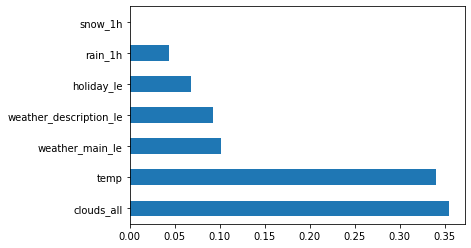

In [19]:
(pd.Series(model.feature_importances_, index=df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le']].columns).nlargest(7)
   .plot(kind='barh'))

In [20]:
df = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']]

In [21]:
df

,rain_1h,temp,snow_1h,clouds_all,holiday_le,weather_main_le,weather_description_le,traffic_volume
0,0.0,288.28,0.0,40,7,1,21,5545
1,0.0,289.36,0.0,75,7,1,2,4516
2,0.0,289.58,0.0,90,7,1,17,4767
3,0.0,290.13,0.0,90,7,1,17,5026
4,0.0,291.14,0.0,75,7,1,2,4918
...,...,...,...,...,...,...,...,...
48199,0.0,283.45,0.0,75,7,1,2,3543
48200,0.0,282.76,0.0,90,7,1,17,2781
48201,0.0,282.73,0.0,90,7,10,19,2159
48202,0.0,282.09,0.0,90,7,1,17,1450


In [22]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [23]:
validate = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(10)
df.drop(df.tail(10).index,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']])
dataY = y_scaler.fit_transform(df[['traffic_volume']])

In [25]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [26]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.         0.92972555 0.         0.4        0.63636364 0.1
  0.7        0.76167582]
 [0.         0.93320863 0.         0.75       0.63636364 0.1
  0.06666667 0.62032967]
 [0.         0.93391815 0.         0.9        0.63636364 0.1
  0.56666667 0.65480769]
 [0.         0.93569194 0.         0.9        0.63636364 0.1
  0.56666667 0.69038462]
 [0.         0.93894927 0.         0.75       0.63636364 0.1
  0.06666667 0.67554945]
 [0.         0.94081981 0.         0.01       0.63636364 0.
  0.73333333 0.71167582]
 [0.         0.94549618 0.         0.01       0.63636364 0.
  0.73333333 0.76703297]
 [0.         0.94772148 0.         0.01       0.63636364 0.
  0.73333333 0.82623626]
 [0.         0.9486245  0.         0.2        0.63636364 0.1
  0.13333333 0.79546703]
 [0.         0.94527042 0.         0.2        0.63636364 0.1
  0.13333333 0.65521978]
 [0.         0.93840101 0.         0.2        0.63636364 0.1
  0.13333333 0.48612637]
 [0.         0.93327313 0. 

In [27]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [28]:
lstm_multi = tf.keras.models.Sequential()
lstm_multi.add(tf.keras.layers.LSTM(150,input_shape=x_train_multi.shape[-2:],return_sequences=True))
lstm_multi.add(tf.keras.layers.Dropout(0.2)),
lstm_multi.add(tf.keras.layers.LSTM(units=100,return_sequences=False)),
lstm_multi.add(tf.keras.layers.Dropout(0.2)),
lstm_multi.add(tf.keras.layers.Dense(units=horizon)),
lstm_multi.compile(optimizer='adam', loss='mse')

In [29]:
model_path = 'drive/MyDrive/Data/LSTM_multivarient_1.h5'

In [30]:
EVALUATION_INTERVAL = 150
EPOCHS = 100
history = lstm_multi.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
150/150 [==============================] - 36s 19ms/step - loss: 0.0984 - val_loss: 0.0480
Epoch 2/100
150/150 [==============================] - 2s 14ms/step - loss: 0.0530 - val_loss: 0.0579
Epoch 3/100
150/150 [==============================] - 2s 14ms/step - loss: 0.0498 - val_loss: 0.0423
Epoch 4/100
150/150 [==============================] - 2s 14ms/step - loss: 0.0470 - val_loss: 0.0394
Epoch 5/100
150/150 [==============================] - 2s 14ms/step - loss: 0.0477 - val_loss: 0.0367
Epoch 6/100
150/150 [==============================] - 2s 15ms/step - loss: 0.0484 - val_loss: 0.0477
Epoch 7/100
150/150 [==============================] - 2s 15ms/step - loss: 0.0405 - val_loss: 0.0325
Epoch 8/100
150/150 [==============================] - 2s 15ms/step - loss: 0.0418 - val_loss: 0.0358
Epoch 9/100
150/150 [==============================] - 2s 15ms/step - loss: 0.0403 - val_loss: 0.0531
Epoch 10/100
150/150 [==============================] - 2s 15ms/step - loss: 0.04

In [31]:
Trained_model = tf.keras.models.load_model(model_path)

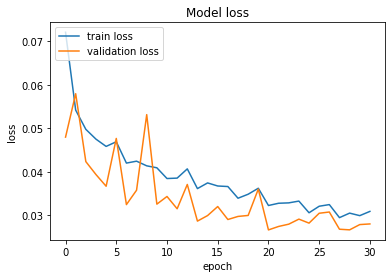

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [33]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 150)           95400     
_________________________________________________________________
dropout (Dropout)            (None, 48, 150)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
Total params: 196,810
Trainable params: 196,810
Non-trainable params: 0
_________________________________________________________________


In [34]:
data_val = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(48))

In [35]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [36]:
Predicted_results = Trained_model.predict(val_rescaled)

In [37]:
Predicted_results

array([[0.65219253, 0.6210711 , 0.62252605, 0.5927712 , 0.5685885 ,
        0.54643   , 0.53598666, 0.5187314 , 0.45484704, 0.39020407]],
      dtype=float32)

In [38]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [39]:
Predicted_results_Inv_trans

array([[4747.9614, 4521.3975, 4531.9897, 4315.374 , 4139.324 , 3978.0103,
        3901.983 , 3776.3647, 3311.2864, 2840.6855]], dtype=float32)

In [40]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [41]:
timeseries_evaluation_metrics_func(validate['traffic_volume'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 1132067.7069983303
MAE is : 789.0581787109375
RMSE is : 1063.9867043334377
MAPE is : 47.65184175857682
R2 is : 0.2650446048081384



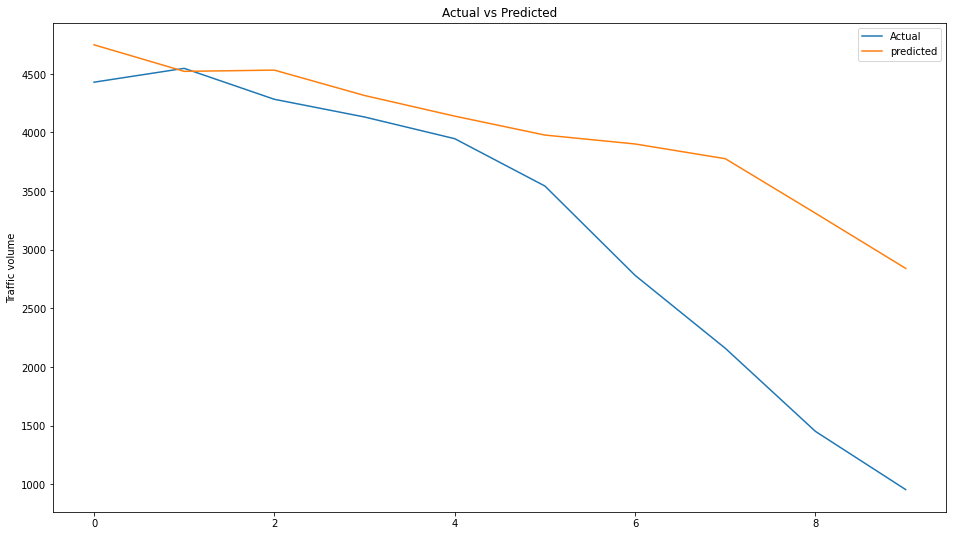

In [42]:
plt.plot( list(validate['traffic_volume']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## BIDIRECTONAL LSTM Multivarient Horizon

In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [44]:
df.head()

,rain_1h,temp,snow_1h,clouds_all,holiday_le,weather_main_le,weather_description_le,traffic_volume
0,0.0,288.28,0.0,40,7,1,21,5545
1,0.0,289.36,0.0,75,7,1,2,4516
2,0.0,289.58,0.0,90,7,1,17,4767
3,0.0,290.13,0.0,90,7,1,17,5026
4,0.0,291.14,0.0,75,7,1,2,4918


In [45]:
df.describe()

,rain_1h,temp,snow_1h,clouds_all,holiday_le,weather_main_le,weather_description_le,traffic_volume
count,35120.000000,35120.000000,35120.000000,35120.000000,35120.000000,35120.000000,35120.000000,35120.000000
mean,0.316492,281.458469,0.000012,39.512927,6.998178,1.566315,14.843081,3321.802249
std,52.463389,14.229468,0.001266,37.796942,0.143966,2.280356,7.850123,1979.798275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,271.657500,0.000000,1.000000,7.000000,0.000000,6.000000,1314.750000
50%,0.000000,283.280000,0.000000,40.000000,7.000000,1.000000,17.000000,3469.000000
75%,0.000000,292.772500,0.000000,75.000000,7.000000,1.000000,22.000000,4970.000000
max,9831.300000,310.070000,0.210000,100.000000,11.000000,10.000000,30.000000,7280.000000


In [46]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

In [47]:
model_path = 'drive/MyDrive/Data/Bidirectional_multivarient_1.h5'

In [48]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 8s 38ms/step - loss: 0.1200 - val_loss: 0.0515
Epoch 2/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0654 - val_loss: 0.0504
Epoch 3/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0560 - val_loss: 0.0601
Epoch 4/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0540 - val_loss: 0.0404
Epoch 5/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0558 - val_loss: 0.0389
Epoch 6/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0481 - val_loss: 0.0388
Epoch 7/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0495 - val_loss: 0.0341
Epoch 8/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0459 - val_loss: 0.0360
Epoch 9/150
100/100 [==============================] - 3s 27ms/step - loss: 0.0410 - val_loss: 0.0408
Epoch 10/150
100/100 [==============================] - 3s 27ms/step - loss: 0.039

In [49]:
 Trained_model = tf.keras.models.load_model(model_path)

In [50]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 48, 300)           190800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 333,430
Trainable params: 333,430
Non-trainable params: 0
_________________________________________________________________


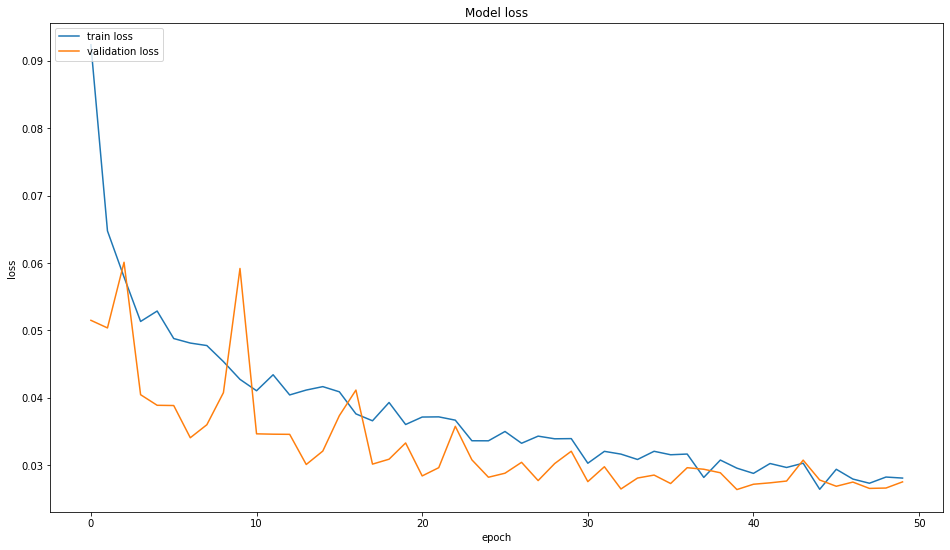

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [52]:
data_val = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(48))

In [53]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [54]:
Predicted_results = Trained_model.predict(val_rescaled)

In [55]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [56]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [57]:
timeseries_evaluation_metrics_func(validate['traffic_volume'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 1195926.9567541599
MAE is : 853.4759765625
RMSE is : 1093.5844534164519
MAPE is : 50.945075219499515
R2 is : 0.22358621866143347



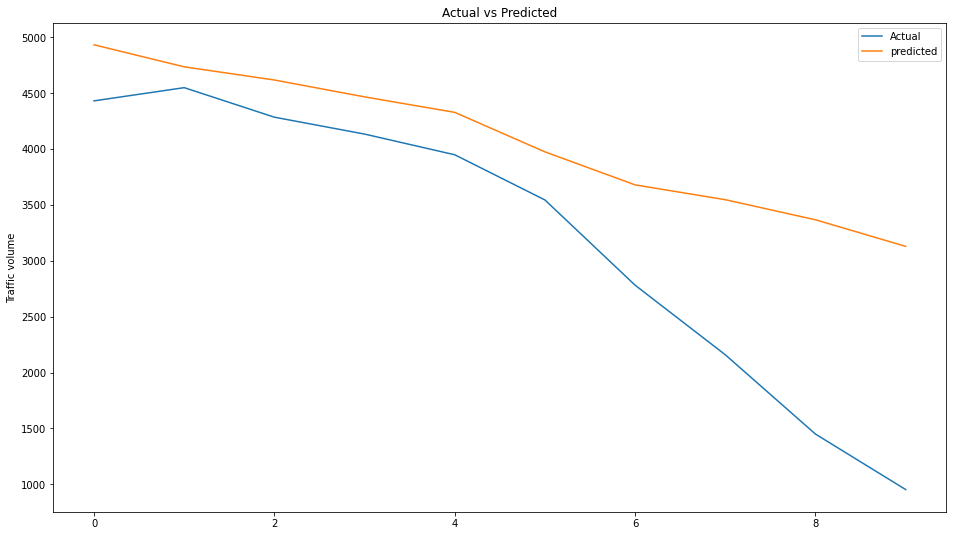

In [58]:
plt.plot( list(validate['traffic_volume']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## GRU Multivarient Horizon Style

In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [60]:
df.head()

,rain_1h,temp,snow_1h,clouds_all,holiday_le,weather_main_le,weather_description_le,traffic_volume
0,0.0,288.28,0.0,40,7,1,21,5545
1,0.0,289.36,0.0,75,7,1,2,4516
2,0.0,289.58,0.0,90,7,1,17,4767
3,0.0,290.13,0.0,90,7,1,17,5026
4,0.0,291.14,0.0,75,7,1,2,4918


In [61]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')


In [62]:
model_path = 'drive/MyDrive/Data/GRU_multivarient_1.h5'

In [63]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 4s 17ms/step - loss: 0.1208 - val_loss: 0.0518
Epoch 2/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0638 - val_loss: 0.0562
Epoch 3/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0541 - val_loss: 0.0674
Epoch 4/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0550 - val_loss: 0.0384
Epoch 5/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0551 - val_loss: 0.0395
Epoch 6/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0477 - val_loss: 0.0355
Epoch 7/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0481 - val_loss: 0.0349
Epoch 8/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0456 - val_loss: 0.0368
Epoch 9/150
100/100 [==============================] - 1s 11ms/step - loss: 0.0414 - val_loss: 0.0398
Epoch 10/150
100/100 [==============================] - 1s 11ms/step - loss: 0.039

In [64]:
Trained_model = tf.keras.models.load_model(model_path)

In [65]:
 # Show the model architecture
Trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 48, 100)           33000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 56,310
Trainable params: 56,310
Non-trainable params: 0
_________________________________________________________________


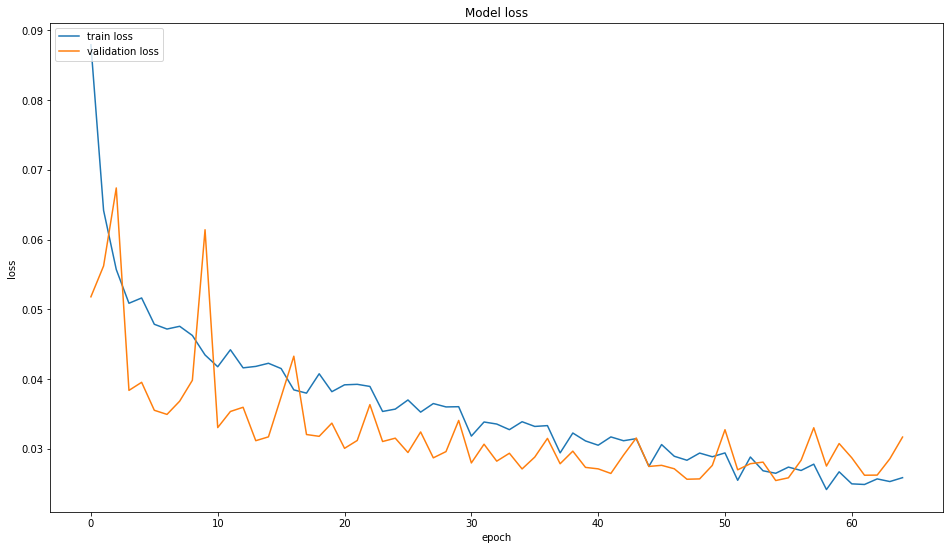

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [67]:
data_val = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(48))

In [68]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [69]:
Predicted_results = Trained_model.predict(val_rescaled)

In [70]:
Predicted_results

array([[0.56232065, 0.5752343 , 0.5889063 , 0.57570714, 0.5526833 ,
        0.53747505, 0.5249715 , 0.4910259 , 0.42977214, 0.37535796]],
      dtype=float32)

In [71]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [72]:
Predicted_results_Inv_trans

array([[4093.6943, 4187.7056, 4287.238 , 4191.148 , 4023.5344, 3912.8184,
        3821.7925, 3574.6685, 3128.7412, 2732.606 ]], dtype=float32)

In [73]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [74]:
timeseries_evaluation_metrics_func(validate['traffic_volume'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 945663.9325431883
MAE is : 711.8146728515625
RMSE is : 972.4525348535981
MAPE is : 43.45875534350683
R2 is : 0.38606074092174947



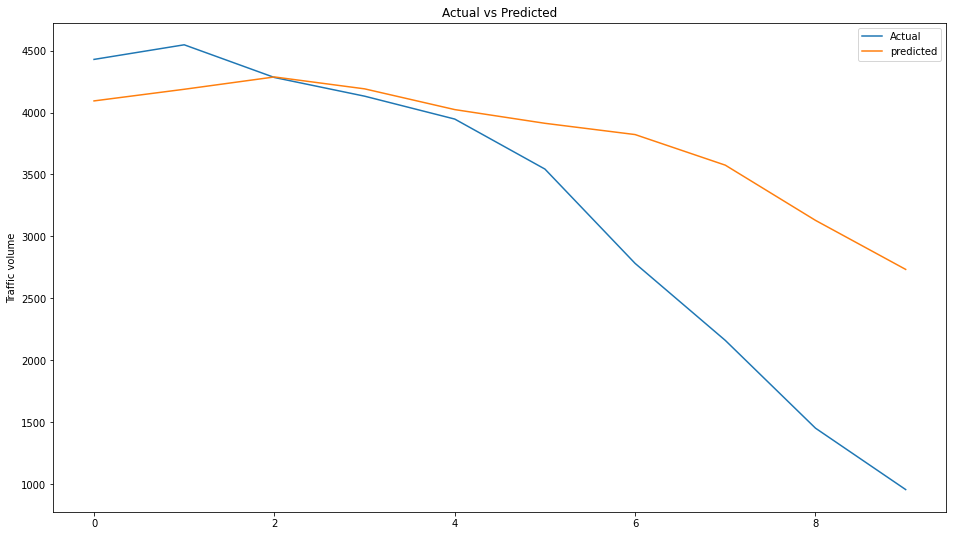

In [75]:
plt.plot( list(validate['traffic_volume']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## ENCODER DECODER LSTM MULTIVARIATE HORIZON

In [76]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(40, input_shape=x_train_multi.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=20,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_multi.shape[1]), 
    tf.keras.layers.LSTM(units=40,return_sequences=True),
    tf.keras.layers.LSTM(units=25,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

## CNN MULTIVARIATE

In [78]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
tf.random.set_seed(123)
np.random.seed(123)

In [79]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_multi.shape[1], x_train_multi.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

This all deep learning technique to solve time series problem 